<a href="https://colab.research.google.com/github/PlayMoodify/PlayMoodify.model/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PlayMoodify


Analisi del dataset ottenuto tramite la piattaforma Kaggle

In [ ]:
# Caricamento del dataset dalla piattaforma kaggle
import kagglehub
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
from IPython.display import display
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, f1_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from IPython.display import display


file_path = "278k_song_labelled.csv"

df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "abdullahorzan/moodify-dataset",
  file_path,
)

In [30]:
# Visualizzazione della struttura dataset, con visualizzazione dei primi 5 record di quest'ultimo
display(df.head())

,Unnamed: 0,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels
0,0,195000.0,0.611,0.614,-8.815,0.0672,0.0169,0.000794,0.7530,0.520,128.050,3.446154e-07,2
1,1,194641.0,0.638,0.781,-6.848,0.0285,0.0118,0.009530,0.3490,0.250,122.985,1.464234e-07,1
2,2,217573.0,0.560,0.810,-8.029,0.0872,0.0071,0.000008,0.2410,0.247,170.044,4.007850e-07,1
3,3,443478.0,0.525,0.699,-4.571,0.0353,0.0178,0.000088,0.0888,0.199,92.011,7.959809e-08,0
4,4,225862.0,0.367,0.771,-5.863,0.1060,0.3650,0.000001,0.0965,0.163,115.917,4.693131e-07,1


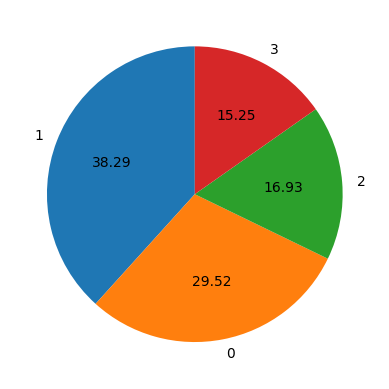

In [31]:
# Distribuzione delle classi {'sad' : 0, 'happy' : 1, 'energetic' : 2, 'calm' : 3}
plt.pie(df["labels"].value_counts().values, labels=df["labels"].value_counts().index, autopct="%.2f", startangle=90)
plt.show()

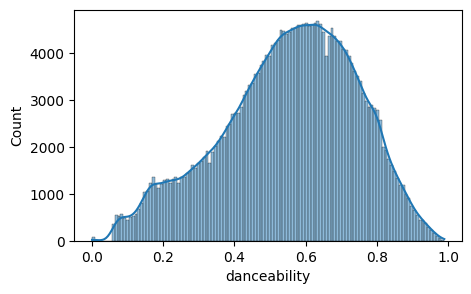

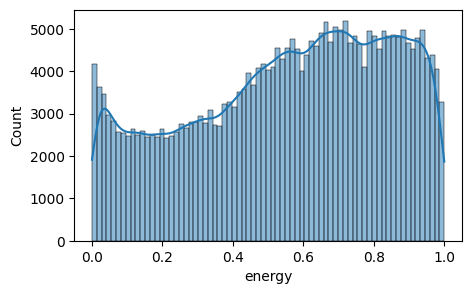

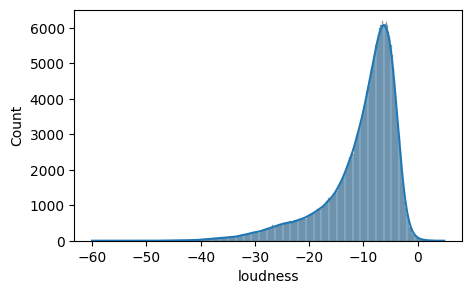

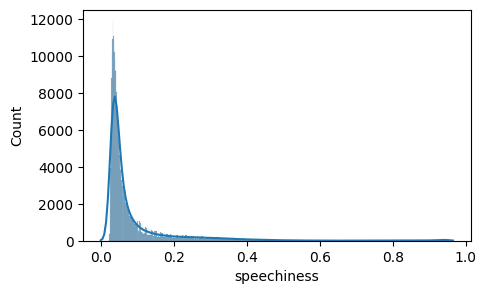

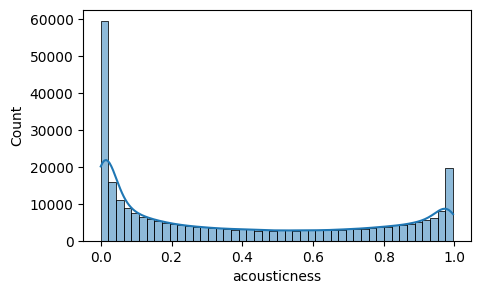

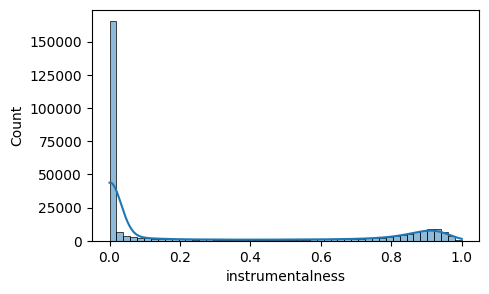

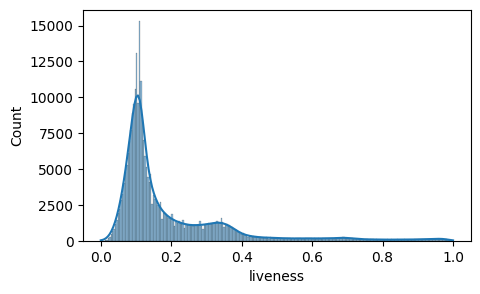

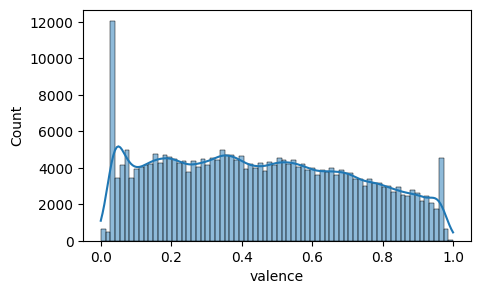

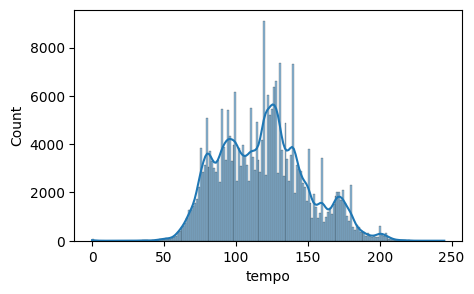

In [32]:
# Analisi della distribuzione delle singole feature all'interno del dataset
plt.figure(figsize=(5, 3))
sns.histplot(df["danceability"], kde=True)
plt.show()

plt.figure(figsize=(5, 3))
sns.histplot(df["energy"], kde=True)
plt.show()

plt.figure(figsize=(5, 3))
sns.histplot(df["loudness"], kde=True)
plt.show()

plt.figure(figsize=(5, 3))
sns.histplot(df["speechiness"], kde=True)
plt.show()

plt.figure(figsize=(5, 3))
sns.histplot(df["acousticness"], kde=True)
plt.show()

plt.figure(figsize=(5, 3))
sns.histplot(df["instrumentalness"], kde=True)
plt.show()

plt.figure(figsize=(5, 3))
sns.histplot(df["liveness"], kde=True)
plt.show()

plt.figure(figsize=(5, 3))
sns.histplot(df["valence"], kde=True)
plt.show()

plt.figure(figsize=(5, 3))
sns.histplot(df["tempo"], kde=True)
plt.show()

Dall’osservazione dei grafici sopra riportati possiamo notare che:
*   La feature Energy risulta essere ben distribuita nella scala tra 0 e 1;
*   Le feature Speechiness e Instrumentalness hanno un alto picco su 0;
*   Le feature Acousticness e Valence hanno picchi sia su 0 che su 1;
*   La feature Danceability ha un picco nei valori che vanno tra 0.4 e 0.8;
*   La feature Liveness ha un picco tra 0 e 0.2, per poi decrescere
drasticamente fino ad 1.







##Individuazione di entry non significative

In [33]:
# Verifichiamo la presenza di brani campionati in modo errato
print((df["spec_rate"] == 0.0).sum())
display(df[df["spec_rate"] == 0.0])

90


,Unnamed: 0,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels
4854,4854,161474.0,0.0,0.93200,-13.238,0.0,0.123000,1.000000,0.7200,0.0,0.0,0.0,0
11951,11951,14040.0,0.0,0.81700,-10.403,0.0,0.650000,0.013600,0.1010,0.0,0.0,0.0,0
13183,13183,189000.0,0.0,0.96800,-5.182,0.0,0.000004,0.000036,0.1160,0.0,0.0,0.0,2
23301,23301,223280.0,0.0,0.16900,-14.467,0.0,0.598000,0.274000,0.2990,0.0,0.0,0.0,0
24380,24380,147000.0,0.0,0.40500,-9.935,0.0,0.842000,0.001140,0.1980,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
269701,269701,11227.0,0.0,0.03040,-17.836,0.0,0.000238,0.596000,0.0694,0.0,0.0,0.0,3
269815,269815,39493.0,0.0,0.00002,-60.000,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.0,0
271602,271602,168720.0,0.0,0.36400,-8.046,0.0,0.671000,0.000000,0.1780,0.0,0.0,0.0,0
272146,272146,188400.0,0.0,0.06440,-18.222,0.0,0.982000,0.598000,0.2680,0.0,0.0,0.0,3


In [34]:
# Verifichiamo la presenza di tracce che hanno tempo (bpm) pari a 0.0, che rappresentano errori di campionamento o tracce che non sono canzoni
print((df["tempo"] == 0.0).sum())
display(df[df["tempo"] == 0.0])

90


,Unnamed: 0,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels
4854,4854,161474.0,0.0,0.93200,-13.238,0.0,0.123000,1.000000,0.7200,0.0,0.0,0.0,0
11951,11951,14040.0,0.0,0.81700,-10.403,0.0,0.650000,0.013600,0.1010,0.0,0.0,0.0,0
13183,13183,189000.0,0.0,0.96800,-5.182,0.0,0.000004,0.000036,0.1160,0.0,0.0,0.0,2
23301,23301,223280.0,0.0,0.16900,-14.467,0.0,0.598000,0.274000,0.2990,0.0,0.0,0.0,0
24380,24380,147000.0,0.0,0.40500,-9.935,0.0,0.842000,0.001140,0.1980,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
269701,269701,11227.0,0.0,0.03040,-17.836,0.0,0.000238,0.596000,0.0694,0.0,0.0,0.0,3
269815,269815,39493.0,0.0,0.00002,-60.000,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.0,0
271602,271602,168720.0,0.0,0.36400,-8.046,0.0,0.671000,0.000000,0.1780,0.0,0.0,0.0,0
272146,272146,188400.0,0.0,0.06440,-18.222,0.0,0.982000,0.598000,0.2680,0.0,0.0,0.0,3


In [35]:
# Verifichiamo la presenza di entry che non rappresentano brani, poichè di durata troppo breve o troppo elevata. Dunque, podcast, ecc...
df["duration (min)"] = df["duration (ms)"] / (1000 * 60)
df.drop("duration (ms)", axis=1, inplace=True)

# Tracce di lunghezza superiore a 10 min
print("TRACCE CON DURATA SUPERIORE A 10 MINUTI: ")
print((df["duration (min)"] > 10).sum())
display(df[df["duration (min)"] > 10])

# Tracce con lunghezza inferiore ad 1 min
print("TRACCE CON DURATA INFERIORE A 1 MINUTO: ")
print((df["duration (min)"] < 1).sum())
display(df[df["duration (min)"] < 1])

TRACCE CON DURATA SUPERIORE A 10 MINUTI: 
2949


,Unnamed: 0,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels,duration (min)
301,301,0.457,0.9650,0.457,0.4860,0.085,0.000000,0.6970,0.6040,170.122,7.682276e-07,2,10.543750
627,627,0.528,0.3490,-18.761,0.0302,0.474,0.497000,0.6280,0.6420,76.097,4.231013e-08,0,11.896283
650,650,0.412,0.4600,-13.222,0.0336,0.118,0.411000,0.7190,0.6040,102.135,4.008795e-08,0,13.969283
651,651,0.590,0.3900,-15.613,0.0335,0.248,0.403000,0.9880,0.5630,104.619,4.761952e-08,0,11.724883
751,751,0.559,0.5110,-11.167,0.0326,0.553,0.802000,0.0865,0.7420,87.999,4.402312e-08,0,12.342000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
275314,275314,0.227,0.1750,-16.656,0.0392,0.906,0.000005,0.0993,0.2130,76.105,5.764138e-08,0,11.334450
275331,275331,0.175,0.3460,-9.170,0.0340,0.661,0.000002,0.6300,0.1520,179.026,5.657389e-08,0,10.016400
275332,275332,0.318,0.2150,-13.555,0.0341,0.868,0.000000,0.2380,0.1960,101.310,3.965116e-08,0,14.333333
275339,275339,0.251,0.3380,-9.224,0.0295,0.838,0.000000,0.1000,0.2080,146.687,4.092510e-08,0,12.013817


TRACCE CON DURATA INFERIORE A 1 MINUTO: 
1680


,Unnamed: 0,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels,duration (min)
1061,1061,0.417,0.1400,-14.404,0.0495,0.712,0.224000,0.1910,0.03940,47.689,1.530234e-06,0,0.539133
1402,1402,0.686,0.4370,-10.040,0.0984,0.601,0.000028,0.1530,0.57900,71.652,1.845012e-06,1,0.888883
1404,1404,0.683,0.4680,-10.058,0.0743,0.870,0.673000,0.1080,0.47000,117.095,1.292264e-06,0,0.958267
1704,1704,0.531,0.4980,-20.324,0.1230,0.385,0.892000,0.3030,0.26100,100.182,2.214341e-06,3,0.925783
1882,1882,0.851,0.3660,-9.884,0.0429,0.918,0.459000,0.3100,0.91100,74.385,8.081379e-07,0,0.884750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276881,276881,0.491,0.2330,-13.970,0.2230,0.898,0.833000,0.1080,0.15800,209.887,3.859400e-06,3,0.963017
276886,276886,0.119,0.7340,-18.570,0.0677,0.505,0.895000,0.1690,0.00001,97.174,1.259371e-06,3,0.895950
277800,277800,0.688,0.5730,-14.046,0.3580,0.778,0.000366,0.3480,0.94800,98.871,6.572787e-06,1,0.907783
277845,277845,0.824,0.0773,-12.007,0.2720,0.918,0.000687,0.0963,0.39300,137.227,6.100159e-06,0,0.743150


##Rimozione di entry e feature non significative

In [36]:
# Rimuoviamo le entry non significative
print(f"Dimensione dataset prima della rimozione delle entry non significative: {df.shape[0]}")
df.drop(df[df["spec_rate"] == 0.0].index, inplace=True)
df.drop(df[df["tempo"] == 0.0].index, inplace=True)
df.drop(df[df["duration (min)"] > 10].index, inplace=True)
df.drop(df[df["duration (min)"] < 1].index, inplace=True)
print(f"Dimensione dataset dopo la rimozione delle entry non significative: {df.shape[0]}")

Dimensione dataset prima della rimozione delle entry non significative: 277938
Dimensione dataset dopo la rimozione delle entry non significative: 273252


In [37]:
# Rimuoviamo le feature non significative
df.drop("duration (min)", axis=1, inplace=True)
df.drop("spec_rate", axis=1, inplace=True)
df.drop("Unnamed: 0", axis=1, inplace=True)
display(df.head())

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,labels
0,0.611,0.614,-8.815,0.0672,0.0169,0.000794,0.7530,0.520,128.050,2
1,0.638,0.781,-6.848,0.0285,0.0118,0.009530,0.3490,0.250,122.985,1
2,0.560,0.810,-8.029,0.0872,0.0071,0.000008,0.2410,0.247,170.044,1
3,0.525,0.699,-4.571,0.0353,0.0178,0.000088,0.0888,0.199,92.011,0
4,0.367,0.771,-5.863,0.1060,0.3650,0.000001,0.0965,0.163,115.917,1


Utilizziamo una matrice di correlazione per individuare il grado di correlazione tra le feature presenti nel dataset

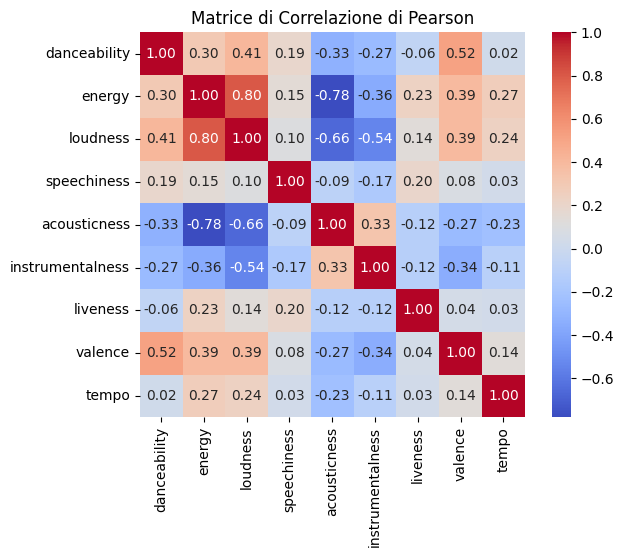

La coppia di feature con più alta correlazione risulta essere:
 energy  loudness    0.803044


In [38]:
# Rimuoviamo la feature label dal dataset di partenza
df_corr = df.drop("labels", axis=1)

# Calcoliamo con il metodo Perason la matrice di correlazione
corr_matrix = df_corr.corr(method = "pearson")

# Visualizzazione della matrice di correlazione
plt.figure(figsize=(7, 5))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True
)
plt.title("Matrice di Correlazione di Pearson")
plt.show()

# Individuazione automatica delle feature ad alta correlazione
threshold = 0.8

# Rappresentazione delle feature con alta correlazione
high_corr_pairs = (
    corr_matrix.abs()
      .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
      .stack()
      .sort_values(ascending=False)
)

result = high_corr_pairs[high_corr_pairs > threshold]
print(f"La coppia di feature con più alta correlazione risulta essere:\n {result.to_string()}")

Dall'analisi della matrice di correlazione emerge un legame molto stretto tra **energy** e **loudness**. Abbiamo scelto di escludere **loudness** per ridurre la ridondanza dei dati, privilegiando **energy** in quanto variabile più indicativa della componente emotiva del brano, rispetto al dato prettamente tecnico del volume. Successivamente ricalcoliamo la matrice di correlazione rimuovendo la feature **loudness**, per verificare la presenza di ulteriori correlazioni causate dalla sua rimozione.

In [39]:
# Rimuoviamo la feature loudness dal dataset
df.drop("loudness", axis=1, inplace=True)

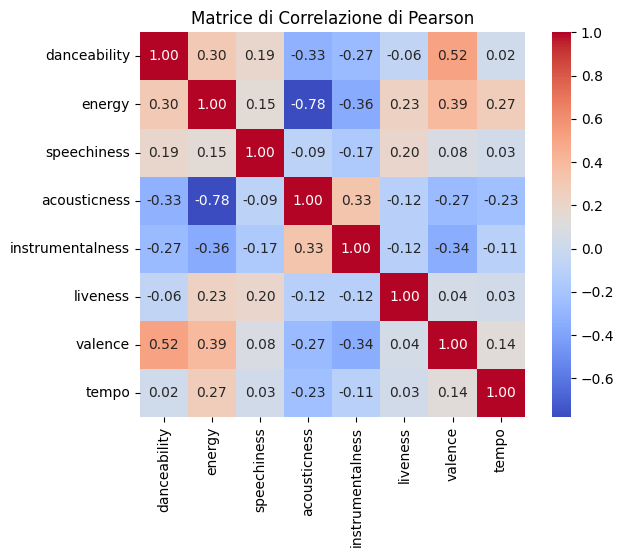

Nessuna coppia supera la soglia di correlazione impostata.


In [40]:
# Rimuoviamo la feature loudness dal dataset
df_corr = df_corr.drop("loudness", axis=1)

# Calcoliamo con il metodo Perason la matrice di correlazione senza loudness
corr_matrix = df_corr.corr(method = "pearson")

# Visualizzazione della matrice di correlazione senza loudness
plt.figure(figsize=(7, 5))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True
)
plt.title("Matrice di Correlazione di Pearson")
plt.show()

# Individuazione automatica delle feature ad alta correlazione
threshold = 0.8

# Rappresentazione delle feature con alta correlazione
high_corr_pairs = (
    corr_matrix.abs()
      .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
      .stack()
      .sort_values(ascending=False)
)

result = high_corr_pairs[high_corr_pairs > threshold]

if not result.empty:
    print(f"La coppia di feature con più alta correlazione risulta essere:\n{result.to_string()}")
else:
    print("Nessuna coppia supera la soglia di correlazione impostata.")

Analizziamo nuovamente la distribuzione delle classi e delle feature nel dataset dopo la pulizia da feature e entry non significative

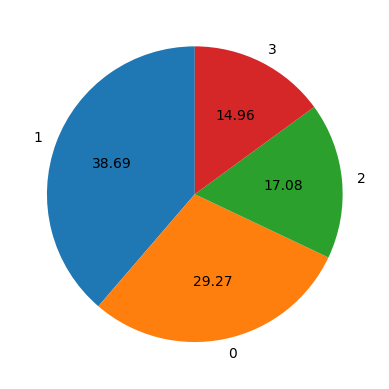

In [41]:
# Distribuzione delle classi dopo la pulizia del dataset
plt.pie(df["labels"].value_counts().values, labels=df["labels"].value_counts().index, autopct="%.2f", startangle=90)
plt.show()

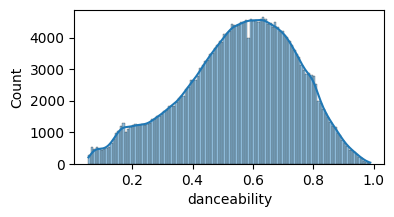

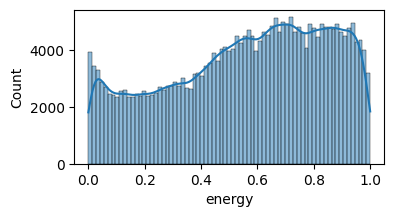

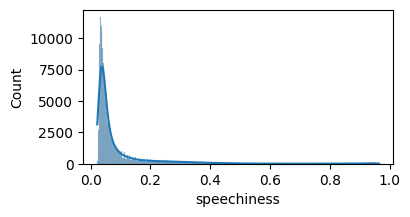

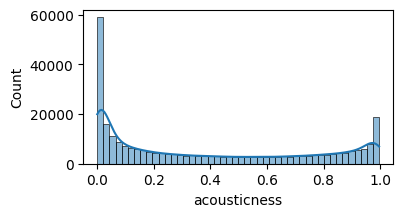

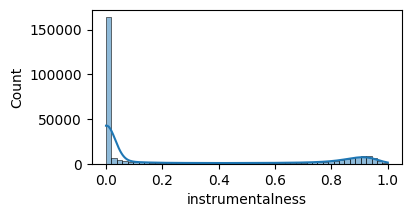

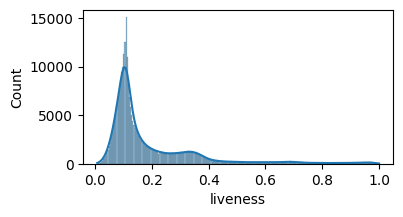

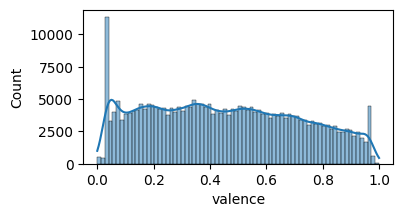

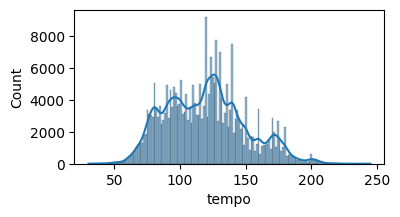

In [42]:
# Analisi della distribuzione delle singole feature dopo la pulizia del dataset
plt.figure(figsize=(4, 2))
sns.histplot(df["danceability"], kde=True)
plt.show()

plt.figure(figsize=(4, 2))
sns.histplot(df["energy"], kde=True)
plt.show()

plt.figure(figsize=(4, 2))
sns.histplot(df["speechiness"], kde=True)
plt.show()

plt.figure(figsize=(4, 2))
sns.histplot(df["acousticness"], kde=True)
plt.show()

plt.figure(figsize=(4, 2))
sns.histplot(df["instrumentalness"], kde=True)
plt.show()

plt.figure(figsize=(4, 2))
sns.histplot(df["liveness"], kde=True)
plt.show()

plt.figure(figsize=(4, 2))
sns.histplot(df["valence"], kde=True)
plt.show()

plt.figure(figsize=(4, 2))
sns.histplot(df["tempo"], kde=True)
plt.show()

Effettuiamo un ultima verifica sulla presenza di missing values nel dataset prima di passare alla fase di split del dataset

In [43]:
print(df.isnull().sum())

danceability        0
energy              0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
labels              0
dtype: int64


Come possiamo osservare, non c'è presenza di valori nulli tra le feature e dunque alcuna necessità di data imputation o eliminazione di entry

Abbiamo suddiviso il dataset seguendo la proporzione 80-20, ispirata al Principio di Pareto. Questa configurazione ci permette di addestrare il modello su una solida base di dati, mantenendo una quota significativa per valutarne le performance su dati mai visti.

In [44]:
# Effettuiamo la suddivisione del dataset
from re import X
X = df.drop("labels", axis=1)
y = df["labels"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Utilizziamo random_state = 42, poichè permette di effettuare uno split pseudo-casuale e riproducibile tramite una funzione deterministica

# Implementazione dei modelli di ML
Dopo aver suddiviso il dataset in training set e test set, passiamo alla fase di scaling sul traning set.

## Pipeline 1: Random Forest
Per la pipeline Random Forest non viene applicato lo scaling delle feature, poichè si tratta di un modello tree-based. Il Random Forest effettua split a soglia sulle singole variabili e non utilizza distanze o prodotti scalari. Lo scaling non comporterebbe benefici in termini di performance e viene quindi omesso per mantenere la pipeline più semplice e preservare l’interpretabilità delle soglie di decisione.
Pertanto, abbiamo scelto di utilizzare il `class_weight='balanced'` invece di **SMOTE**, poiché, essendo un modello tree-based, riesce a gestire in modo efficase lo sbilanciamento tramite l'utilizzo pesi di classe, evitando l’introduzione di campioni sintetici e riducendo il rischio di overfitting o presenza di pattern sintetici.



In [45]:
# Creiamo un modello di Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=300, # numero di alberi decisionali che verrano creati
    random_state=42,
    class_weight='balanced', # da peso maggiore alle classi minoritarie, bilancia senza inserimento di valori sintetici
    n_jobs=-1, # velocizza il training utilizzando tutti i core, evitando approccio sequenziale che sarebbe più lento
    oob_score=True
)

In [46]:
# Effettuiamo una stima delle performace solo sul training set
rf_clf.fit(X_train, y_train)
print("OOB score:", rf_clf.oob_score_)

OOB score: 0.9183809772141939


In questa sezione analizziamo l'efficacia del modello attraverso le metriche di Accuracy, Precision, Recall e F1-Score.

Performance del modello:
Accuracy: 0.920


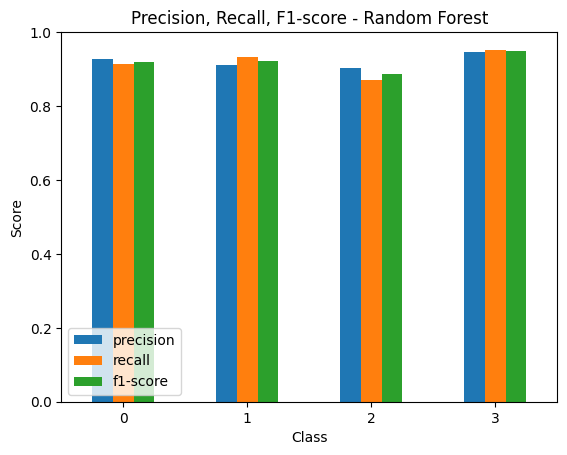

Tabella delle metriche per classe (Random Forest):


,precision,recall,f1-score
0,0.927,0.914,0.920
1,0.910,0.934,0.922
2,0.904,0.870,0.886
3,0.947,0.952,0.949


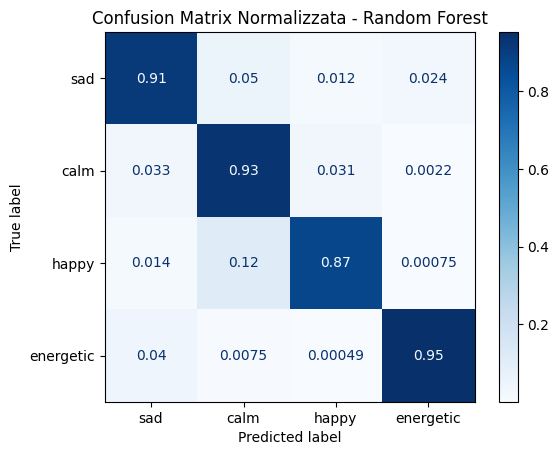

In [47]:
# Performance confrontando i valori predetti con quelli del test set
y_pred_rf = rf_clf.predict(X_test)
report_dict_rf = classification_report(y_test, y_pred_rf, output_dict=True)

print("Performance del modello:")

# Accuracy del modello
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {acc_rf:.3f}")

# Conversione in DataFrame
report_rf_df = pd.DataFrame(report_dict_rf).T

# Selezione solo delle classi (esclude accuracy)
per_class_rf_df = report_rf_df.iloc[:-3][['precision', 'recall', 'f1-score']]

# Plot
per_class_rf_df.plot(kind='bar')
plt.title("Precision, Recall, F1-score - Random Forest")
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(loc='lower left')
plt.show()

print("Tabella delle metriche per classe (Random Forest):")

metrics_table = per_class_rf_df.copy().round(3)
display(metrics_table)

# Visualizzazione Confusion Matrix
class_names = ['sad', 'calm', 'happy', 'energetic']

disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf,
    X_test,
    y_test,
    display_labels=class_names,
    normalize='true',
    cmap='Blues'
)

plt.title("Confusion Matrix Normalizzata - Random Forest")
plt.show()

## Pipeline 2: Logistic Regression
Per quanto riguarda la pipeline con logistic regression, quest'ultima necessita di scaling delle feature, poichè è un modello gradient-based e basato su ottimizzazione numerica.
Dunque, lo scaling delle feature è necessario poichè evita effetti negativi come:
*   Coefficienti distorti
*   Instabilità numerica
*   Interpretazione errata delle feature
*   Performance peggiori

In particolare, abbiamo deciso di utilizzare la standardizzazione, in quanto, in presenza di scale molto diverse, feature con valori alti possono essere avvantaggiate a discapito di feature con valori inferiori.
Algoritmi gradient-based, come la Logistic Regression, risultano essere instabili in presenza di feature con ordini di grandezze diversi. Pertanto, la scelta più adeguata risulta essere la standardizzazione, poichè riduce il divario tra le grandezze di feature differenti, facendo si che queste abbiamo media pari a 0 e deviazione standard pari a 1. In questo modo, si evita la situazione in cui feature con scale maggiori dominino la stima dei pesi.





In [48]:
# Implementiamo la standardizzazione

scaler = StandardScaler()

# Applichiamo la standardizzazione sul training set
X_train_scaled = scaler.fit_transform(X_train)

# Applichiamo separatamente la standardizzazione sul test set corrispondente
X_test_scaled = scaler.transform(X_test)

## Gestione dello sbilanciamento delle classi
Per la Logistic Regression, lo sbilanciamento delle classi viene gestito con **SMOTE** (Synthetic Minority Over-sampling Technique), che genera campioni sintetici per la classe minoritaria nel training set.
Questo permette di bilanciare le classi durante l’addestramento e migliorare le performance del modello.

In [49]:
# Implementazione della SMOTE

smote_lr = SMOTE(random_state=42)
X_train_smote_lr, y_train_smote_lr = smote_lr.fit_resample(X_train_scaled, y_train)

In [50]:
# Creazione del modello Logistic Regression

lr_clf = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    random_state=42
)
lr_clf.fit(X_train_smote_lr, y_train_smote_lr)

LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

Performance del modello:
Accuracy: 0.812


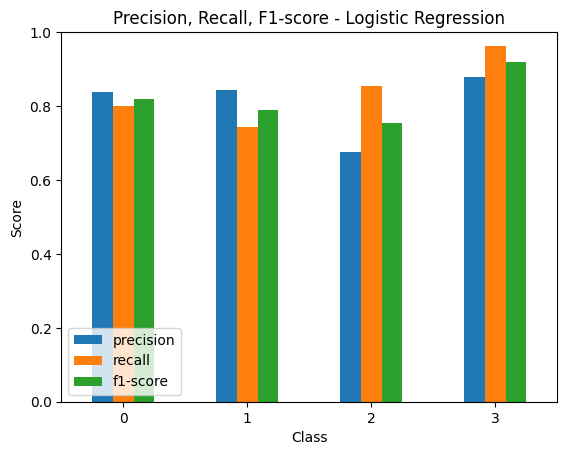

Tabella delle metriche per classe (Logistic Regression):


,precision,recall,f1-score
0,0.839,0.801,0.820
1,0.844,0.743,0.790
2,0.677,0.854,0.755
3,0.879,0.964,0.919


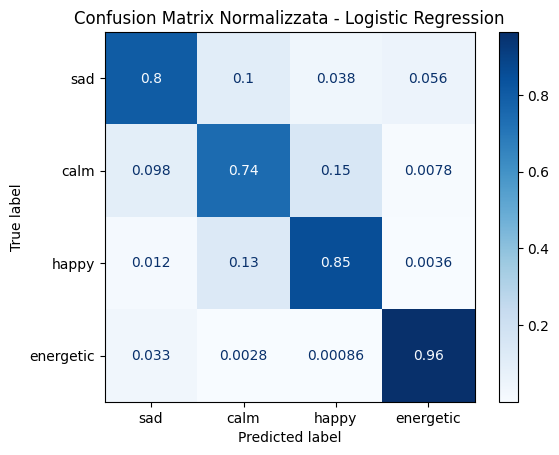

In [51]:
# Performance confrontando i valori predetti con quelli del test set
y_pred_lr = lr_clf.predict(X_test_scaled)
report_dict_lr = classification_report(y_test, y_pred_lr, output_dict=True)

print("Performance del modello:")

# Accuracy del modello
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {acc_lr:.3f}")

# Conversione in DataFrame
report_lr_df = pd.DataFrame(report_dict_lr).T

# Selezione solo delle classi (esclude accuracy)
per_class_lr_df = report_lr_df.iloc[:-3][['precision', 'recall', 'f1-score']]

# Plot
per_class_lr_df.plot(kind='bar')
plt.title("Precision, Recall, F1-score - Logistic Regression")
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(loc='lower left')
plt.show()

print("Tabella delle metriche per classe (Logistic Regression):")

metrics_table = per_class_lr_df.copy().round(3)
display(metrics_table)

# Visualizzazione Confusion Matrix
class_names = ['sad', 'calm', 'happy', 'energetic']

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_lr,
    normalize='true',
    display_labels=class_names,
    cmap='Blues',
)

plt.title("Confusion Matrix Normalizzata - Logistic Regression")
plt.show()

# Confronto performance tra le due pipeline
Le due pipeline (Random Forest e Logistic Regression) sono state confrontate mediante metriche aggregate (accuracy, macro F1, weighted F1 e macro recall) al fine di valutare in modo oggettivo le prestazioni e il comportamento dei modelli in presenza di class imbalance. Il confronto consente di evidenziare i trade-off tra capacità predittiva, stabilità sulle classi minoritarie e interpretabilità del modello.

In [52]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
# Performance Random Forest
print("Performance del modello Random Forest")

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1_macro = f1_score(y_test, y_pred_rf, average='macro')
rf_recall_macro = recall_score(y_test, y_pred_rf, average='macro')


Performance del modello Random Forest


In [53]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
#Performance Logistic Regression
print("Performance del modello Logistic Regression")

lr_acc = accuracy_score(y_test, y_pred_lr)
lr_f1_macro = f1_score(y_test, y_pred_lr, average='macro')
lr_recall_macro = recall_score(y_test, y_pred_lr, average='macro')


Performance del modello Logistic Regression


In [54]:
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression'],
    'Accuracy': [rf_acc, lr_acc],
    'Macro F1': [rf_f1_macro, lr_f1_macro],
    'Macro Recall': [rf_recall_macro, lr_recall_macro]
})

comparison_df

,Model,Accuracy,Macro F1,Macro Recall
0,Random Forest,0.919654,0.919554,0.917252
1,Logistic Regression,0.812282,0.821233,0.840705


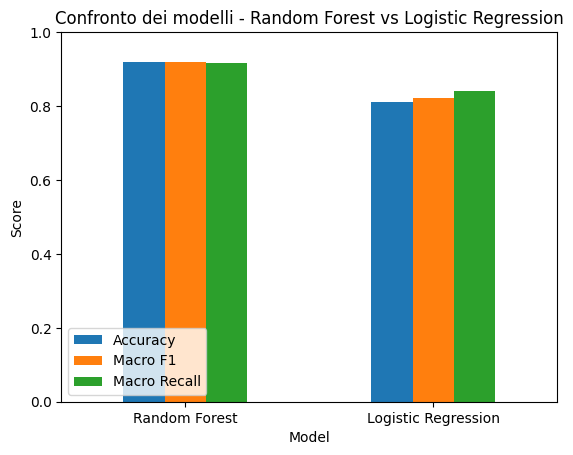

In [55]:
# Grafico di confronto
comparison_df.set_index('Model').plot(kind='bar')
plt.title("Confronto dei modelli - Random Forest vs Logistic Regression")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=360)
plt.legend(loc='lower left')
plt.show()

Random Forest è stato selezionato come modello finale in quanto ha ottenuto performance superiori rispetto alla Logistic Regression su tutte le principali metriche (accuracy, macro F1, macro recall), dimostrando una maggiore capacità di generalizzazione e una migliore gestione delle classi minoritarie.

## Salvataggio del modello addestrato

In [56]:
joblib.dump(rf_clf, 'PlayMoodify.pkl')

['PlayMoodify.pkl']